In [276]:
import sys
sys.path.extend(['/home/quic/QUIC-Projects'])

import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
DATA_DIR = Path("/home/quic/QUIC-Projects/summary_ipynb/2022/06 June/02 Thu")
OBJ_FUNC = r'$\mathcal{L}_{\phi, \lambda}$'

In [277]:
plt.style.use('./styles/figstyle.mplstyle')
plt.style.reload_library()

In [278]:
from pandas import read_csv, DataFrame

training_data = np.load(DATA_DIR/'training_data.npy')
test_data = np.load(DATA_DIR/'test_data.npy')
training_label = np.load(DATA_DIR/'training_label.npy')
test_label = np.load(DATA_DIR/'test_label.npy')

In [279]:
import dill
import json

with open(DATA_DIR/'sv_storage', 'rb') as fp:
    sv_storage = dill.load(fp)

with open(DATA_DIR/'qasm_storage', 'rb') as fp:
    qasm_storage = dill.load(fp)

with open(DATA_DIR/'sv_qasvm', 'rb') as fp:
    sv_qasvm = dill.load(fp)

with open(DATA_DIR/'qasm_qasvm', 'rb') as fp:
    qasm_qasvm = dill.load(fp)

sv_fvec = np.load(DATA_DIR/'sv_fvec.npy')
qasm_fvec = np.load(DATA_DIR/'qasm_fvec.npy')

In [280]:
from classifiers.convex.svm import CvxSoftQASVM

training_kernel = sv_qasvm.kernel_matrix
test_kernel = sv_qasvm._qk.evaluate(test_data, training_data)

svm = CvxSoftQASVM(kernel='precomputed', C=10**4, lamda=10**4)
svm.fit(training_kernel, training_label)
true_f = svm.f(test_kernel)

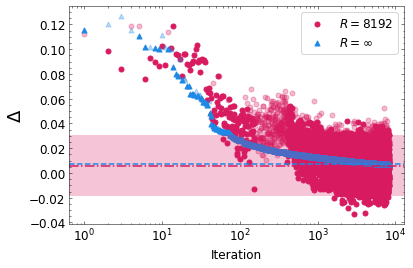

In [293]:
colors = list(map(lambda x: x['color'], plt.rcParams['axes.prop_cycle']))


df1 = qasm_storage.data
df2 = sv_storage.data
with plt.rc_context(rc={'figure.figsize':(6, 4), 'lines.markersize':5}):
    fig, ax = plt.subplots()
    ax.scatter(df1.loc[df1['Accepted']==True]['Step'], df1.loc[df1['Accepted']==True]['Cost']-svm.dual_objective_value, marker='o', c=colors[0], label=fr'$R={qasm_qasvm.quantum_instance.run_config.shots}$')
    #ax.scatter(range(len(df1.loc[df1['Accepted']==True])), df1.loc[df1['Accepted']==True]['Cost']-svm.dual_objective_value, marker='.', c=color1, label='QASVM')
    ax.scatter(df1.loc[df1['Accepted']==False]['Step'], df1.loc[df1['Accepted']==False]['Cost']-svm.dual_objective_value, marker='o', alpha=0.3, c=colors[0])
    ax.scatter(df2.loc[df2['Accepted']==True]['Step'], df2.loc[df2['Accepted']==True]['Cost']-svm.dual_objective_value, marker='^', c=colors[1], label=r'$R=\infty$')
    #ax.scatter(range(len(df2.loc[df2['Accepted']==True])), df2.loc[df2['Accepted']==True]['Cost']-svm.dual_objective_value, marker='.', c=color2, label='QEKM')
    ax.scatter(df2.loc[df2['Accepted']==False]['Step'], df2.loc[df2['Accepted']==False]['Cost']-svm.dual_objective_value, marker='^', alpha=0.3, c=colors[1])
    ax.axhline(sv_storage.last_cost_avg(16, ignore_rejected=True)-svm.dual_objective_value, 0, 1, color=colors[1], linestyle='dashed')
    ax.axhline(qasm_storage.last_cost_avg(16, ignore_rejected=True)-svm.dual_objective_value, 0, 1, color=colors[0], linestyle='dashdot')
    ax.axhspan(ymin=qasm_storage.last_cost_avg(16, ignore_rejected=True)-svm.dual_objective_value-2*qasm_storage.last_cost_std(16, ignore_rejected=True),
                ymax=qasm_storage.last_cost_avg(16, ignore_rejected=True)-svm.dual_objective_value+2*qasm_storage.last_cost_std(16, ignore_rejected=True),
                xmin=0, xmax=1, facecolor=colors[0], alpha=0.25)
    ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.set_xlabel('Iteration')
    ax.set_ylabel(r'$\Delta$', fontsize=1.5*plt.rcParams['font.size'])
    ax.legend(loc='upper right')

fig.savefig('./figs/numerical_analysis_shot_noise.png', dpi=300)
fig.savefig('./figs/numerical_analysis_shot_noise.svg', dpi=300)
fig.savefig('./figs/numerical_analysis_shot_noise.pdf', dpi=300)

In [282]:
np.mean(np.abs(qasm_fvec-true_f))

0.010935102077375901

In [283]:
np.mean(np.abs(sv_fvec-true_f))

0.009291909035367361

In [284]:
qasm_fvec_list = []
from tqdm import tqdm

for _ in tqdm(range(10)):
    qasm_fvec_list.append(qasm_qasvm.f(test_data))

result_list = []
for _fvec in qasm_fvec_list:
    result_list.append(np.mean(np.abs(_fvec-true_f)))

print(np.mean(result_list), np.std(result_list))

100%|██████████| 10/10 [06:28<00:00, 38.85s/it]

0.011888029523506038 0.0008024745055903194


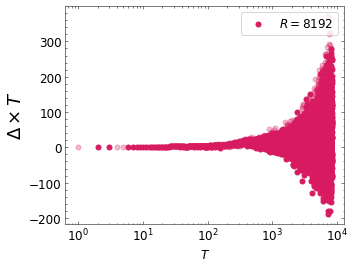

In [295]:
colors = list(map(lambda x: x['color'], plt.rcParams['axes.prop_cycle']))

df1 = qasm_storage.data
df2 = sv_storage.data
with plt.rc_context(rc={'figure.figsize':(5, 4), 'lines.markersize':5}):
    fig, ax = plt.subplots()
    steps = df1.loc[df1['Accepted']==True]['Step']
    delta = df1.loc[df1['Accepted']==True]['Cost']-svm.dual_objective_value
    steps_ = df1.loc[df1['Accepted']==False]['Step']
    delta_ = df1.loc[df1['Accepted']==False]['Cost']-svm.dual_objective_value

    ax.scatter(steps, steps*delta, marker='o', c=colors[0], label=fr'$R={qasm_qasvm.quantum_instance.run_config.shots}$')
    #ax.scatter(range(len(df1.loc[df1['Accepted']==True])), df1.loc[df1['Accepted']==True]['Cost']-svm.dual_objective_value, marker='.', c=color1, label='QASVM')
    ax.scatter(steps_, steps_*delta_, marker='o', alpha=0.3, c=colors[0])

    ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.set_xlabel(r'$T$')
    ax.set_ylabel(r'$\Delta\times T$', fontsize=1.5*plt.rcParams['font.size'])
    ax.legend(loc='upper right')

# fig.savefig('./figs/numerical_analysis_shot_noise.png', dpi=300)
# fig.savefig('./figs/numerical_analysis_shot_noise.svg', dpi=300)
# fig.savefig('./figs/numerical_analysis_shot_noise.pdf', dpi=300)

In [296]:
def coarse_grain(x, y, d, acc=None):
    x = np.log10(x)
    new_x = []
    new_y = []
    min_x = min(x)
    max_x = max(x)
    is_acc = []

    for i, _x in enumerate(x):
        if (_x>min_x+d) & (_x<max_x-d):
            _ind = (x<_x+d) * (x>_x-d)
            new_x.append(_x)
            if sum(_ind):
                new_y.append(np.sum(y[_ind])/np.sum(_ind))
            else:
                new_y.append(y[i])
            if acc is not None:
                is_acc.append(acc[i])
    if acc is not None:
        return 10**np.array(new_x), np.array(new_y), np.array(is_acc)
    else:
        return 10**np.array(new_x), np.array(new_y)


In [297]:
steps = df1['Step']
delta = df1['Cost']-svm.dual_objective_value
accval = df1["Accepted"]

new_steps, new_delta, new_accval = coarse_grain(steps[10:], np.array(delta[10:]), 0.1, accval)

steps_ = df2['Step']
delta_ = df2['Cost']-svm.dual_objective_value
accval_ = df2["Accepted"]

new_steps_, new_delta_, new_accval_ = coarse_grain(steps_[10:], np.array(delta_[10:]), 0.1, accval_)

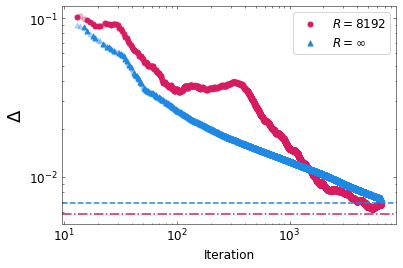

In [299]:
colors = list(map(lambda x: x['color'], plt.rcParams['axes.prop_cycle']))


df1 = qasm_storage.data
df2 = sv_storage.data
with plt.rc_context(rc={'figure.figsize':(6, 4), 'lines.markersize':5}):
    fig, ax = plt.subplots()
    ax.scatter(new_steps[new_accval], new_delta[new_accval], c=colors[0], marker='o', label=fr'$R={qasm_qasvm.quantum_instance.run_config.shots}$')
    ax.scatter(new_steps[~new_accval], new_delta[~new_accval], c=colors[0], marker='o', alpha=0.3)
    ax.scatter(new_steps_[new_accval_], new_delta_[new_accval_], c=colors[1], marker='^', label=r'$R=\infty$')
    ax.scatter(new_steps_[~new_accval_], new_delta_[~new_accval_], c=colors[1], marker='^', alpha=0.3)
    #ax.scatter(range(len(df2.loc[df2['Accepted']==True])), df2.loc[df2['Accepted']==True]['Cost']-svm.dual_objective_value, marker='.', c=color2, label='QEKM')
    #ax.axhline(sv_storage.last_cost_avg(16, ignore_rejected=True)-svm.dual_objective_value, 0, 1, color=colors[1], linestyle='dashed')
    #ax.axhline(qasm_storage.last_cost_avg(16, ignore_rejected=True)-svm.dual_objective_value, 0, 1, color=colors[0], linestyle='dashdot')
    ax.axhline(sv_storage.last_cost_avg(16, ignore_rejected=True)-svm.dual_objective_value, 0, 1, color=colors[1], linestyle='dashed')
    ax.axhline(qasm_storage.last_cost_avg(16, ignore_rejected=True)-svm.dual_objective_value, 0, 1, color=colors[0], linestyle='dashdot')
    # ax.axhspan(ymin=qasm_storage.last_cost_avg(16, ignore_rejected=True)-svm.dual_objective_value-2*qasm_storage.last_cost_std(16, ignore_rejected=True),
    #         ymax=qasm_storage.last_cost_avg(16, ignore_rejected=True)-svm.dual_objective_value+2*qasm_storage.last_cost_std(16, ignore_rejected=True),
    #         xmin=0, xmax=1, facecolor=colors[0], alpha=0.25)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Iteration')
    ax.set_ylabel(r'$\Delta$', fontsize=1.5*plt.rcParams['font.size'])
    ax.legend(loc='upper right')

fig.savefig('./figs/numerical_analysis_no_shot_noise.png', dpi=300)
fig.savefig('./figs/numerical_analysis_no_shot_noise.svg', dpi=300)
fig.savefig('./figs/numerical_analysis_no_shot_noise.pdf', dpi=300)

In [289]:
def coarse_grain2(x, y, d):
    new_x = []
    new_y = []
    min_x = min(x)
    max_x = max(x)

    for i, _x in enumerate(x):
        if (_x>min_x+d) & (_x<max_x-d):
            _ind = (x<_x+d) * (x>_x-d)
            new_x.append(_x)
            if sum(_ind):
                new_y.append(np.sum(y[_ind])/np.sum(_ind))
            else:
                new_y.append(y[i])
    return np.array(new_x), np.array(new_y)

In [290]:
steps = df1['Step']
delta = df1['Cost']-svm.dual_objective_value

new_steps, new_delta = coarse_grain2(steps, np.array(delta), 64)

steps_ = df2['Step']
delta_ = df2['Cost']-svm.dual_objective_value

new_steps_, new_delta_ = coarse_grain2(steps_, np.array(delta_), 64)

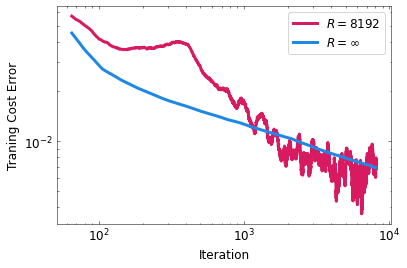

In [291]:
colors = list(map(lambda x: x['color'], plt.rcParams['axes.prop_cycle']))


df1 = qasm_storage.data
df2 = sv_storage.data
with plt.rc_context(rc={'figure.figsize':(6, 4), 'lines.linewidth':3}):
    fig, ax = plt.subplots()
    ax.plot(new_steps, new_delta, c=colors[0], label=fr'$R={qasm_qasvm.quantum_instance.run_config.shots}$')
    ax.plot(new_steps_, new_delta_, c=colors[1], label=r'$R=\infty$')
    #ax.scatter(range(len(df2.loc[df2['Accepted']==True])), df2.loc[df2['Accepted']==True]['Cost']-svm.dual_objective_value, marker='.', c=color2, label='QEKM')
    #ax.axhline(sv_storage.last_cost_avg(16, ignore_rejected=True)-svm.dual_objective_value, 0, 1, color=colors[1], linestyle='dashed')
    #ax.axhline(qasm_storage.last_cost_avg(16, ignore_rejected=True)-svm.dual_objective_value, 0, 1, color=colors[0], linestyle='dashdot')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Traning Cost Error')
    ax.legend(loc='upper right')

# fig.savefig('./figs/numerical_analysis_no_shot_noise.png', dpi=300)
# fig.savefig('./figs/numerical_analysis_no_shot_noise.svg', dpi=300)
# fig.savefig('./figs/numerical_analysis_no_shot_noise.pdf', dpi=300)